In this notebook, we want to summarize the data and make sure that it is behaving as we expect based on previous literature. Here, we want to only use the outcome for tumor_cell_evaluation

Tumor score is defined by UCSF pathologists in the following way: <br>

0: neuropil without tumor <br>
1: infiltrating tumor margin containing a detectable but not abundant number of tumor cells <br>
2: more cellular infiltrated zone <br>
3: highly cellular tumor <br>

In [2]:
recgli = read.csv("../../ParseData/8thParse_researchPath_withInVivo.csv") 
dim(recgli)

[1] 391  74

In [3]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

#### In this notebook, we want to find: <br>
1. perfusion params vs. TS using <br>
    a. No separation into ROIs <br>
    b. Visual comparison of perfusion params in separate regions <br>
    c. Use GLMM associate perfusion parameters with TS, no separation <br>
    d. Use GEE to associate perfusion parameters with TS, no separation <br>
    e. Use RM ANOVA to try to associate outcome w/ imaging params (not other way around!) <br>
    f. Use GLMM to associate perfusion parameters with TS, separating into CEL & NEL <br>
    g. Use GEE to associate perfusion parameters with TS, separating into CEL & NEL <br>
    
2. Combining perf params vs. TS using GEE 
3. Using in_CEL as a covariate in perf params using GEE 

## 0. Prep the data

In [4]:
recgli = recgli[recgli$tumor_cell_evaluation != "Ind",]
dim(recgli)
recgli = droplevels(recgli)
recgli$tumor_cell_evaluation = as.character(recgli$tumor_cell_evaluation)
recgli$tumor_cell_evaluation = as.numeric(recgli$tumor_cell_evaluation)
str(recgli$tumor_cell_evaluation)
colnames(recgli)

[1] 383  74

 num [1:383] 0 2 2 2 0 1 0 2 1 0 ...


[1] "b_number"                  "t_number"                 
 [3] "sf_number"                 "current_scan_date"        
 [5] "current_surgery_date"      "current_hist_grade"       
 [7] "current_hist_type"         "roi.label"                
 [9] "tumor_cell_evaluation"     "necrosis"                 
[11] "f8_delicate"               "f8_simple"                
[13] "f8_complex"                "mib_1"                    
[15] "bx_pure_treatment_effect"  "nfse"                     
[17] "nfl"                       "nt1c"                     
[19] "nt1v"                      "nadc.1"                   
[21] "nfa.1"                     "nev1.1"                   
[23] "nev2.1"                    "nev3.1"                   
[25] "nevrad.1"                  "nadc.2"                   
[27] "nfa.2"                     "nev1.2"                   
[29] "nev2.2"                    "nev3.2"                   
[31] "nevrad.2"                  "cbvn_nlin"                
[33] "phn_nlin"                  "phn_npar"                 
[35] "recovn_npar"               "cni"                      
[37] "ccri"                      "crni"                     
[39] "ncho"                      "ncre"                     
[41] "nnaa"                      "nlip"                     
[43] "laclip"                    "nlac"                     
[45] "olddata"                   "newdata"                  
[47] "comments"                  "notes."                   
[49] "imaging_code"              "perf_quant"               
[51] "cbv_nlin"                  "spec_quant"               
[53] "include_anat"              "include_diffu1000"        
[55] "include_diffu2000"         "include_diffu_all"        
[57] "include_perf"              "include_spec"             
[59] "include_one_advanced_mod"  "include_all_advanced_mods"
[61] "X.CEL"                     "X.NEL"                    
[63] "X.NEC"                     "sum"                      
[65] "in_CEL"                    "in_T2all"                 
[67] "in_NEL"                    "in_NEC"                   
[69] "in_ROI"                    "desired_hist"             
[71] "multnom_out"               "no_ffpe"                  
[73] "waiting_on_path"           "rhgg_txe_analysis"

In [5]:
table(recgli$include_perf)
table(recgli$perf_quant)
recgli[which(recgli$include_perf ==1),]


  0   1 
172 211 


                                      all_zeros           extreme_value 
                    211                      28                       1 
noPerf_or_makePerfIssue     perf_align-nonexist       PERF_BIOPSY_ISSUE 
                    119                      15                       2 
  t_B_outside_perfusion 
                      7 

b_number t_number sf_number current_scan_date current_surgery_date
1   2723      6369     8122     9/13/09           9/14/09             
2   2312      5317     7679     5/4/08            5/4/08              
3   3169      7540     8796     6/19/11           6/20/11             
4   2312      5317     7679     5/4/08            5/4/08              
5   2379      5950     7930     1/25/09           1/26/09             
6   2873      6709     8269     3/11/10           3/15/10             
7   3118      7394     8688     3/15/11           3/16/11             
8   2873      6709     8269     3/11/10           3/15/10             
9   3118      7394     8688     3/15/11           3/16/11             
10  2793      7584     8842     7/28/11           7/28/11             
11  2222      6094     7758     8/3/08            8/4/08              
12  2873      6709     8269     3/11/10           3/15/10             
14  2118      6260     8085     7/27/09           7/29/09             
15  2723      6369     8122     9/13/09           9/14/09             
16  2192      8070     7540     11/18/07          11/19/07            
17  2563      5983     7949     2/8/09            2/9/09              
21   963      6069     7984     3/24/09           3/25/09             
22  2118      6260     8085     7/27/09           7/29/09             
23  2863      6682     8274     3/16/10           3/17/10             
24  2113      4966     7514     10/9/07           10/10/07            
31  2229      5296     7668     4/22/08           4/23/08             
32  2395      5610     7767     8/6/08            8/8/08              
33  3171      7553     8804     6/24/11           6/27/11             
34  2693      6274     8093     8/5/09            8/7/09              
35  2693      6274     8093     8/5/09            8/7/09              
36  1514      7555     8808     6/28/11           6/29/11             
37  2417      5680     7798     9/7/08            9/8/08              
38  1514      7555     8808     6/28/11           6/29/11             
41  2717      6313     8114     9/2/09            9/3/09              
42  1514      7555     8808     6/28/11           6/29/11             
43  2395      5610     7767     8/6/08            8/8/08              
44  3155      7484     8749     5/9/11            5/9/11              
45  1514      7555     8808     6/28/11           6/29/11             
47  1257      6206     8048     6/19/09           6/22/09             
48  3155      7484     8749     5/9/11            5/9/11              
50  1257      6206     8048     6/19/09           6/22/09             
51  2808      6551     8217     1/12/10           1/13/10             
53  2419      5681     7796     9/7/08            9/8/08              
54  1257      6206     8048     6/19/09           6/22/09             
55  2350      5538     7728     7/6/08            7/7/08              
57  2360      5365     7705     6/5/08            6/6/08              
58  1556      5535     7725     7/1/08            7/2/08              
59  2419      5681     7796     9/7/08            9/8/08              
61  2723      6369     8122     9/13/09           9/14/09             
62  2757      6415     8158     10/27/09          10/28/09            
63  2419      5681     7796     9/7/08            9/8/08              
64  2202      5788     7844     10/28/08          10/29/08            
65  2202      5788     7844     10/28/08          10/29/08            
66  2202      5788     7844     10/28/08          10/29/08            
67  2693      6274     8093     8/5/09            8/7/09              
68  2693      6274     8093     8/5/09            8/7/09              
69  2791      6556     8218     1/12/10           1/13/10             
71  2808      6551     8217     1/12/10           1/13/10             
72  3009      7329     8649     2/8/11            2/9/11              
73  3009      7329     8649     2/8/11            2/9/11              
74  2988      7039     7640 

In [6]:
recgli.perf = recgli[recgli$include_perf==1,]
dim(recgli.perf)

[1] 211  74

In [7]:
recgli = recgli.perf
recgli$t_number = as.factor(recgli$t_number)
colnames(recgli)

[1] "b_number"                  "t_number"                 
 [3] "sf_number"                 "current_scan_date"        
 [5] "current_surgery_date"      "current_hist_grade"       
 [7] "current_hist_type"         "roi.label"                
 [9] "tumor_cell_evaluation"     "necrosis"                 
[11] "f8_delicate"               "f8_simple"                
[13] "f8_complex"                "mib_1"                    
[15] "bx_pure_treatment_effect"  "nfse"                     
[17] "nfl"                       "nt1c"                     
[19] "nt1v"                      "nadc.1"                   
[21] "nfa.1"                     "nev1.1"                   
[23] "nev2.1"                    "nev3.1"                   
[25] "nevrad.1"                  "nadc.2"                   
[27] "nfa.2"                     "nev1.2"                   
[29] "nev2.2"                    "nev3.2"                   
[31] "nevrad.2"                  "cbvn_nlin"                
[33] "phn_nlin"                  "phn_npar"                 
[35] "recovn_npar"               "cni"                      
[37] "ccri"                      "crni"                     
[39] "ncho"                      "ncre"                     
[41] "nnaa"                      "nlip"                     
[43] "laclip"                    "nlac"                     
[45] "olddata"                   "newdata"                  
[47] "comments"                  "notes."                   
[49] "imaging_code"              "perf_quant"               
[51] "cbv_nlin"                  "spec_quant"               
[53] "include_anat"              "include_diffu1000"        
[55] "include_diffu2000"         "include_diffu_all"        
[57] "include_perf"              "include_spec"             
[59] "include_one_advanced_mod"  "include_all_advanced_mods"
[61] "X.CEL"                     "X.NEL"                    
[63] "X.NEC"                     "sum"                      
[65] "in_CEL"                    "in_T2all"                 
[67] "in_NEL"                    "in_NEC"                   
[69] "in_ROI"                    "desired_hist"             
[71] "multnom_out"               "no_ffpe"                  
[73] "waiting_on_path"           "rhgg_txe_analysis"

In [8]:
## we want to remove those that have "Indeterminate" 

## 1. Perfusion vs. TS 

### a. No separation into ROIs

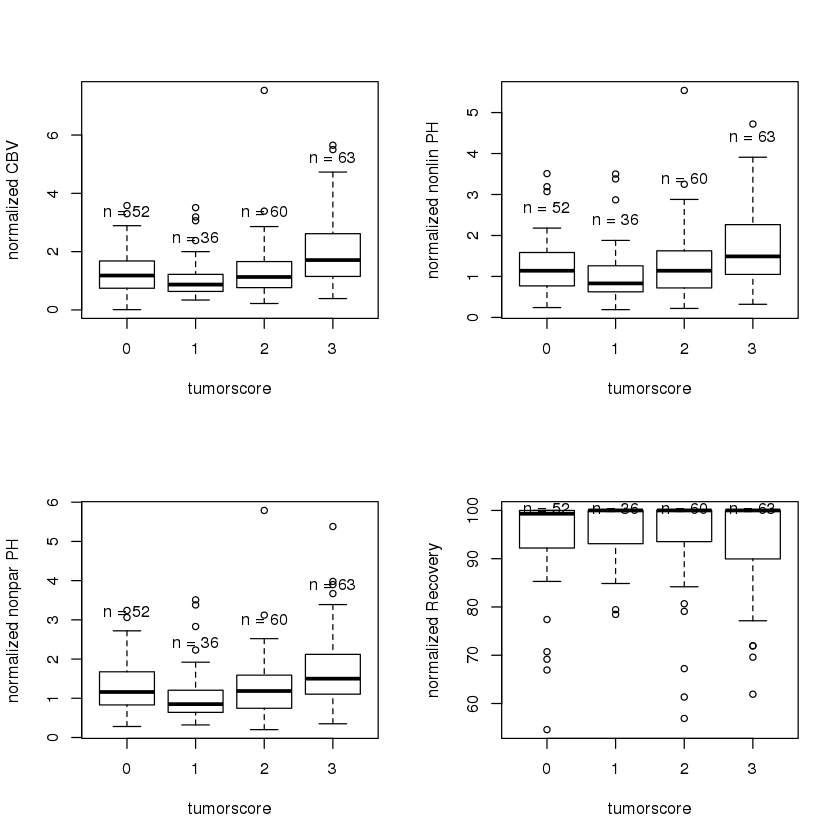

In [9]:
par(mfrow = c(2, 2))
a = boxplot(cbvn_nlin ~ tumor_cell_evaluation , data = recgli, ylab = "normalized CBV", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , a$stats[nrow(a$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

b = boxplot(phn_nlin ~ tumor_cell_evaluation , data = recgli, ylab = "normalized nonlin PH", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , b$stats[nrow(b$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

c = boxplot(phn_npar ~ tumor_cell_evaluation , data = recgli, ylab = "normalized nonpar PH", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , c$stats[nrow(c$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

d = boxplot(recovn_npar ~ tumor_cell_evaluation , data = recgli, ylab = "normalized Recovery", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , d$stats[nrow(d$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )


### b. CEL next to NEL scores  


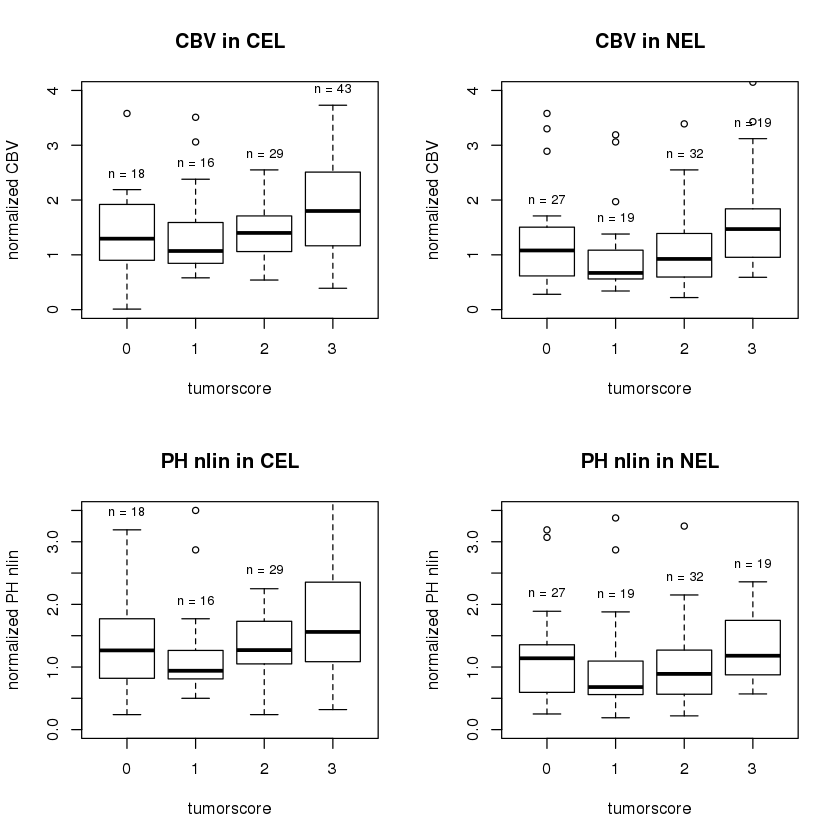

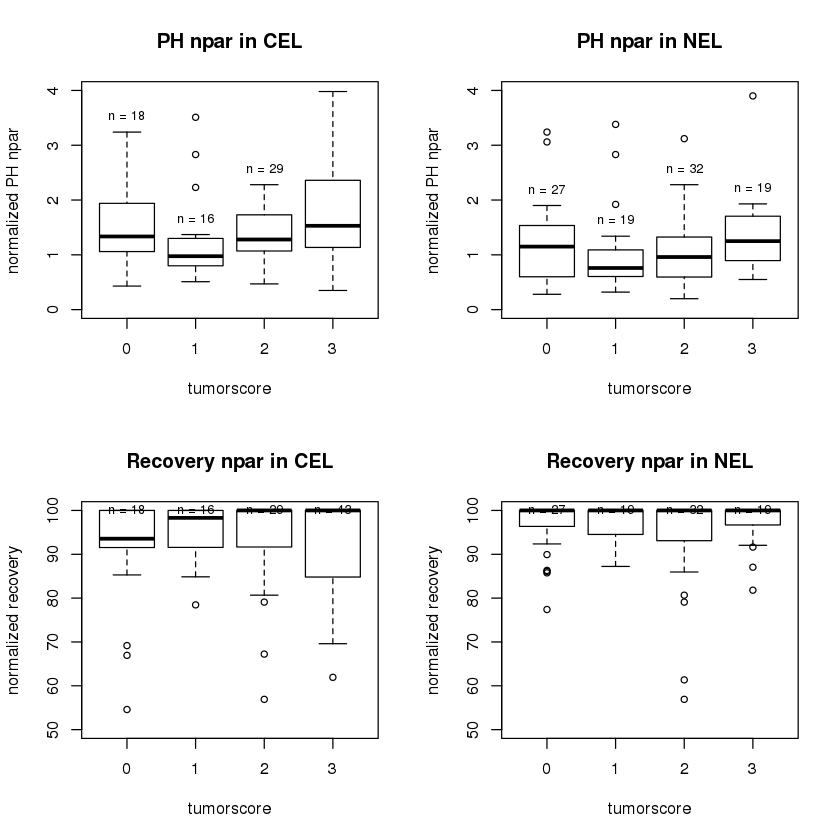

In [10]:
par(mfrow = c(2, 2))
a = boxplot(cbvn_nlin ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized CBV", xlab = "tumorscore", main = "CBV in CEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , a$stats[nrow(a$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_CEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

b = boxplot(cbvn_nlin ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized CBV", xlab = "tumorscore", main = "CBV in NEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , b$stats[nrow(b$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_NEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

c = boxplot(phn_nlin ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized PH nlin", xlab = "tumorscore", main = "PH nlin in CEL", ylim = c(0,3.5))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , c$stats[nrow(c$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_CEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)
d = boxplot(phn_nlin ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized PH nlin", xlab = "tumorscore", main = "PH nlin in NEL", ylim = c(0,3.5))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , d$stats[nrow(d$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_NEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

e = boxplot(phn_npar ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized PH npar", xlab = "tumorscore", main = "PH npar in CEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , e$stats[nrow(e$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
f = boxplot(phn_npar ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized PH npar", xlab = "tumorscore", main = "PH npar in NEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , f$stats[nrow(f$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)

g = boxplot(recovn_npar ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized recovery", xlab = "tumorscore", main = "Recovery npar in CEL", ylim = c(50, 100))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , g$stats[nrow(g$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
h = boxplot(recovn_npar ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized recovery", xlab = "tumorscore", main = "Recovery npar in NEL", ylim = c(50, 100))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , h$stats[nrow(h$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)


### c. Use GLMM associate perf parameters with TS, no separation 


In [1]:
library(mlogit)

Loading required package: Formula
Loading required package: maxLik
Loading required package: miscTools

Please cite the 'maxLik' package as:
Henningsen, Arne and Toomet, Ott (2011). maxLik: A package for maximum likelihood estimation in R. Computational Statistics 26(3), 443-458. DOI 10.1007/s00180-010-0217-1.

If you have questions, suggestions, or comments regarding the 'maxLik' package, please use a forum or 'tracker' at maxLik's R-Forge site:
https://r-forge.r-project.org/projects/maxlik/


In [11]:
data_mlog <-mlogit.data(recgli,  id.var ="t_number", shape="wide", 
                        sep="", varying=NULL, 
                       choice = "tumor_cell_evaluation")

In [13]:
mlogit_phn_nlin <- mlogit(tumor_cell_evaluation ~1 | phn_nlin, data=data_mlog)
summary(mlogit_phn_nlin)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | phn_nlin, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.24645 0.17062 0.28436 0.29858 

nr method
5 iterations, 0h:0m:0s 
g'(-H)^-1g = 3.65E-06 
successive function values within tolerance limits 

Coefficients :
               Estimate Std. Error z-value Pr(>|z|)   
1:(intercept)  0.075606   0.442490  0.1709 0.864330   
2:(intercept)  0.013916   0.374144  0.0372 0.970331   
3:(intercept) -0.753258   0.380362 -1.9804 0.047661 * 
1:phn_nlin    -0.389402   0.345295 -1.1277 0.259431   
2:phn_nlin     0.103065   0.257960  0.3995 0.689497   
3:phn_nlin     0.653332   0.238246  2.7423 0.006102 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -279.13
McFadden R^2:  0.031127 
Likelihood ratio test : chisq = 17.935 (p.value = 0.00045365)

In [14]:
mlogit_cbvn_nlin <- mlogit(tumor_cell_evaluation ~1 | cbvn_nlin, data=data_mlog)
summary(mlogit_cbvn_nlin)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | cbvn_nlin, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.24645 0.17062 0.28436 0.29858 

nr method
5 iterations, 0h:0m:0s 
g'(-H)^-1g = 6.62E-06 
successive function values within tolerance limits 

Coefficients :
               Estimate Std. Error z-value  Pr(>|z|)    
1:(intercept) -0.057853   0.431230 -0.1342 0.8932774    
2:(intercept) -0.065659   0.367882 -0.1785 0.8583471    
3:(intercept) -0.997278   0.383933 -2.5975 0.0093896 ** 
1:cbvn_nlin   -0.255706   0.311592 -0.8206 0.4118494    
2:cbvn_nlin    0.157174   0.238475  0.6591 0.5098463    
3:cbvn_nlin    0.745213   0.223262  3.3378 0.0008443 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -275.41
McFadden R^2:  0.044039 
Likelihood ratio test : chisq = 25.374 (p.value = 1.2893e-05)

In [15]:
mlogit_phn_npar <- mlogit(tumor_cell_evaluation ~1 | phn_npar, data=data_mlog)
summary(mlogit_phn_npar)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | phn_npar, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.24645 0.17062 0.28436 0.29858 

nr method
5 iterations, 0h:0m:0s 
g'(-H)^-1g = 3.03E-06 
successive function values within tolerance limits 

Coefficients :
               Estimate Std. Error z-value Pr(>|z|)  
1:(intercept)  0.097972   0.457058  0.2144  0.83027  
2:(intercept)  0.042794   0.386058  0.1108  0.91174  
3:(intercept) -0.708830   0.389343 -1.8206  0.06867 .
1:phn_npar    -0.391629   0.344588 -1.1365  0.25574  
2:phn_npar     0.077308   0.259624  0.2978  0.76588  
3:phn_npar     0.608295   0.239223  2.5428  0.01100 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -280.06
McFadden R^2:  0.027874 
Likelihood ratio test : chisq = 16.061 (p.value = 0.0011019)

In [16]:
mlogit_recovn_npar <- mlogit(tumor_cell_evaluation ~1 | recovn_npar, data=data_mlog)
summary(mlogit_recovn_npar)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | recovn_npar, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.24645 0.17062 0.28436 0.29858 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 3.9E-08 
gradient close to zero 

Coefficients :
                Estimate Std. Error z-value Pr(>|z|)
1:(intercept) -2.8857147  2.5285266 -1.1413   0.2538
2:(intercept) -1.0917245  1.9760201 -0.5525   0.5806
3:(intercept)  0.0417767  1.8379363  0.0227   0.9819
1:recovn_npar  0.0265168  0.0264405  1.0029   0.3159
2:recovn_npar  0.0130719  0.0208202  0.6278   0.5301
3:recovn_npar  0.0015974  0.0194578  0.0821   0.9346

Log-Likelihood: -287.38
McFadden R^2:  0.0024773 
Likelihood ratio test : chisq = 1.4274 (p.value = 0.69912)

### d. Use GEE to associate perf parameters with TS, no separation


In [11]:
library(glmnet)
library(geepack)
library(lme4)
#install.packages("multgee")
library("multgee")

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: gnm
Loading required package: VGAM
Loading required package: stats4
Loading required package: splines


None of the below works b/c the algorithm won't converge 

In [12]:
#cbvn_nlin.fit = ordLORgee(formula = tumor_cell_evaluation ~ cbvn_nlin, link = "logit", 
#                      id = t_number, data = recgli, LORstr = "category.exch", bstart = c(-0.91188, -0.25897, 1, 2.7137))
#summary(cbvn_nlin.fit)$coefficients


In [13]:
#phn_nlin.fit = ordLORgee(formula = tumor_cell_evaluation ~ phn_nlin, link = "logit", 
#                      id = t_number, data = recgli, LORstr = "category.exch")
#summary(phn_nlin.fit)$coefficients

In [14]:
#phn_npar.fit = ordLORgee(formula = tumor_cell_evaluation ~ phn_npar, link = "logit", 
#                      id = t_number, data = recgli, LORstr = "category.exch")
#summary(phn_npar.fit)$coefficients

In [15]:
#recovn_npar.fit = ordLORgee(formula = tumor_cell_evaluation ~ recovn_npar, link = "logit", 
#                      id = t_number, data = recgli, LORstr = "category.exch")
#summary(recovn_npar.fit)$coefficients

### e. Use RM ANOVA to try to associate outcome w/ imaging params (not other way around!) 

In [16]:
## more statistically straightforward to use RM anova w/ dependent variable 

In [17]:
library(ez)

In [18]:
data.frame(index = 1:length(colnames(recgli)), colnames = colnames(recgli))

index colnames                 
1   1    b_number                 
2   2    t_number                 
3   3    sf_number                
4   4    current_scan_date        
5   5    current_surgery_date     
6   6    current_hist_grade       
7   7    current_hist_type        
8   8    roi.label                
9   9    tumor_cell_evaluation    
10 10    necrosis                 
11 11    f8_delicate              
12 12    f8_simple                
13 13    f8_complex               
14 14    mib_1                    
15 15    bx_pure_treatment_effect 
16 16    nfse                     
17 17    nfl                      
18 18    nt1c                     
19 19    nt1v                     
20 20    nadc.1                   
21 21    nfa.1                    
22 22    nev1.1                   
23 23    nev2.1                   
24 24    nev3.1                   
25 25    nevrad.1                 
26 26    nadc.2                   
27 27    nfa.2                    
28 28    nev1.2                   
29 29    nev2.2                   
30 30    nev3.2                   
31 31    nevrad.2                 
32 32    cbvn_nlin                
33 33    phn_nlin                 
34 34    phn_npar                 
35 35    recovn_npar              
36 36    cni                      
37 37    ccri                     
38 38    crni                     
39 39    ncho                     
40 40    ncre                     
41 41    nnaa                     
42 42    nlip                     
43 43    laclip                   
44 44    nlac                     
45 45    olddata                  
46 46    newdata                  
47 47    comments                 
48 48    notes.                   
49 49    imaging_code             
50 50    perf_quant               
51 51    cbv_nlin                 
52 52    spec_quant               
53 53    include_anat             
54 54    include_diffu1000        
55 55    include_diffu2000        
56 56    include_diffu_all        
57 57    include_perf             
58 58    include_spec             
59 59    include_one_advanced_mod 
60 60    include_all_advanced_mods
61 61    X.CEL                    
62 62    X.NEL                    
63 63    X.NEC                    
64 64    sum                      
65 65    in_CEL                   
66 66    in_T2all                 
67 67    in_NEL                   
68 68    in_NEC                   
69 69    in_ROI                   
70 70    desired_hist             
71 71    multnom_out              
72 72    no_ffpe                  
73 73    waiting_on_path          
74 74    rhgg_txe_analysis

In [19]:
str(recgli[,c(2,9, 32, 45)])
dim(recgli)

'data.frame':	211 obs. of  4 variables:
 $ t_number             : Factor w/ 113 levels "4966","5272",..: 43 4 70 4 20 57 66 57 66 74 ...
 $ tumor_cell_evaluation: num  0 2 2 2 0 1 0 2 1 0 ...
 $ cbvn_nlin            : num  0.66 2.24 0.58 1.71 2.89 0.78 0.94 1.09 0.58 1.43 ...
 $ olddata              : int  1 1 1 1 1 1 1 1 1 1 ...


[1] 211  74

In [20]:
#cbvn_nlin.rmaov = ezANOVA(data = recgli[,c(2,9, 32, 45)], 
#                          dv = tumor_cell_evaluation, 
#                          within = .(cbvn_nlin),
#                          wid = t_number,
#                          detailed = TRUE)

In [21]:
# checking for balance: 
!is.list(replications(~tumor_cell_evaluation,recgli))

Warning message in replications(~tumor_cell_evaluation, recgli):
“non-factors ignored: tumor_cell_evaluation”

[1] TRUE

In [22]:
options(contrasts=c(unordered="contr.sum", ordered="contr.poly"))

In [23]:
cbvn_nlin.rmaov = aov(tumor_cell_evaluation ~ cbvn_nlin + Error(t_number/(cbvn_nlin)), data=recgli)
summary(cbvn_nlin.rmaov)

Warning message in aov(tumor_cell_evaluation ~ cbvn_nlin + Error(t_number/(cbvn_nlin)), :
“Error() model is singular”


Error: t_number
           Df Sum Sq Mean Sq F value   Pr(>F)    
cbvn_nlin   1  31.69   31.69   17.12 6.86e-05 ***
Residuals 111 205.46    1.85                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: t_number:cbvn_nlin
          Df Sum Sq Mean Sq F value Pr(>F)
cbvn_nlin  1  0.032  0.0321   0.073  0.787
Residuals 65 28.456  0.4378               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 32  13.26  0.4144               

In [24]:
phn_nlin.rmaov = aov(tumor_cell_evaluation ~ phn_nlin + Error(t_number/phn_nlin), data=recgli)
summary(phn_nlin.rmaov)

Warning message in aov(tumor_cell_evaluation ~ phn_nlin + Error(t_number/phn_nlin), :
“Error() model is singular”


Error: t_number
           Df Sum Sq Mean Sq F value  Pr(>F)   
phn_nlin    1  21.35  21.350   10.98 0.00124 **
Residuals 111 215.80   1.944                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: t_number:phn_nlin
          Df Sum Sq Mean Sq F value Pr(>F)
phn_nlin   1  0.037  0.0373   0.087  0.769
Residuals 66 28.325  0.4292               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 31  13.39  0.4319               

In [25]:
phn_npar.rmaov = aov(tumor_cell_evaluation ~ phn_npar + Error(t_number/phn_npar), data=recgli)
summary(phn_npar.rmaov)

Warning message in aov(tumor_cell_evaluation ~ phn_npar + Error(t_number/phn_npar), :
“Error() model is singular”


Error: t_number
           Df Sum Sq Mean Sq F value  Pr(>F)   
phn_npar    1  18.31  18.310   9.287 0.00288 **
Residuals 111 218.84   1.972                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: t_number:phn_npar
          Df Sum Sq Mean Sq F value Pr(>F)
phn_npar   1  0.017  0.0170   0.039  0.844
Residuals 66 28.715  0.4351               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 31  13.02  0.4199               

In [26]:
recovn_npar.rmaov = aov(tumor_cell_evaluation ~ recovn_npar + Error(t_number/recovn_npar), data=recgli)
summary(recovn_npar.rmaov)

Warning message in aov(tumor_cell_evaluation ~ recovn_npar + Error(t_number/recovn_npar), :
“Error() model is singular”


Error: t_number
             Df Sum Sq Mean Sq F value Pr(>F)
recovn_npar   1   0.03  0.0339   0.016    0.9
Residuals   111 237.12  2.1362               

Error: t_number:recovn_npar
            Df Sum Sq Mean Sq F value Pr(>F)
recovn_npar  1  0.123  0.1235   0.278  0.601
Residuals   47 20.898  0.4446               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 50  20.73  0.4146               

In [27]:
recovn_npar.rmaov = aov(tumor_cell_evaluation ~ cbvn_nlin+phn_nlin+phn_npar+recovn_npar + Error(t_number), data=recgli)
summary(recovn_npar.rmaov)


Error: t_number
             Df Sum Sq Mean Sq F value   Pr(>F)    
cbvn_nlin     1  31.69   31.69  17.372 6.22e-05 ***
phn_nlin      1   3.51    3.51   1.922    0.168    
phn_npar      1   4.31    4.31   2.362    0.127    
recovn_npar   1   0.67    0.67   0.365    0.547    
Residuals   108 196.99    1.82                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
            Df Sum Sq Mean Sq F value Pr(>F)
cbvn_nlin    1   0.03  0.0321   0.073  0.788
phn_nlin     1   0.01  0.0055   0.013  0.911
phn_npar     1   0.07  0.0702   0.159  0.691
recovn_npar  1   0.09  0.0921   0.208  0.649
Residuals   94  41.55  0.4420               

In [28]:
recovn_npar.rmaov = aov(tumor_cell_evaluation ~ cbvn_nlin*phn_npar + Error(t_number), data=recgli)
summary(recovn_npar.rmaov)


Error: t_number
                    Df Sum Sq Mean Sq F value   Pr(>F)    
cbvn_nlin            1  31.69   31.69  17.849 4.98e-05 ***
phn_npar             1   7.28    7.28   4.104   0.0452 *  
cbvn_nlin:phn_npar   1   4.68    4.68   2.636   0.1073    
Residuals          109 193.50    1.78                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
                   Df Sum Sq Mean Sq F value Pr(>F)  
cbvn_nlin           1   0.03  0.0321   0.076 0.7839  
phn_npar            1   0.01  0.0145   0.034 0.8536  
cbvn_nlin:phn_npar  1   1.42  1.4232   3.357 0.0701 .
Residuals          95  40.28  0.4240                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### f. Use GLMM to associate perfusion parameters with TS, separating into CEL & NEL <br>


In [29]:
## need to come back to when becomes more obvious how to do GLMM with multinomial outcome... 
##can do this using a one-v-all method 

### g. Use GEE to associate anatomical parameters with TS, separating into CEL & NEL 

In [30]:
recgli_inCEL = recgli[which(recgli$in_CEL == 1),]
dim(recgli_inCEL)
is.numeric(recgli_inCEL$tumor_cell_evaluation)
head(recgli_inCEL)

[1] 106  74

[1] TRUE

b_number t_number sf_number current_scan_date current_surgery_date
1  2723     6369     8122      9/13/09           9/14/09             
2  2312     5317     7679      5/4/08            5/4/08              
4  2312     5317     7679      5/4/08            5/4/08              
6  2873     6709     8269      3/11/10           3/15/10             
9  3118     7394     8688      3/15/11           3/16/11             
11 2222     6094     7758      8/3/08            8/4/08              
   current_hist_grade current_hist_type roi.label tumor_cell_evaluation
1  Grade IV           Glioblastoma      10B28     0                    
2  Grade IV           Glioblastoma      11B16     2                    
4  Grade IV           Glioblastoma      12B16     2                    
6  Grade IV           Glioblastoma      13B32     1                    
9  Treatment Effect   Treatment Effect  14B41     1                    
11 Grade IV           Glioblastoma      15B18     0                    
   necrosis f8_delicate f8_simple f8_complex mib_1 bx_pure_treatment_effect
1  0        2           1         0           0.82 t                       
2  1        2           3         0           3.31 f                       
4  1        3           2         0          12.84 f                       
6  0        2           0         0           7.70 f                       
9  0        0           0         0           2.01 f                       
11 0        1           2         0           0.00 t                       
   nfse nfl  nt1c nt1v nadc.1 nfa.1 nev1.1 nev2.1 nev3.1 nevrad.1 nadc.2 nfa.2
1  2.10 1.84 1.20 0.84 1.31   0.75  1.19   1.28   1.58   1.45       NA     NA 
2  2.27 1.44 1.88 0.78 1.92   0.68  1.63   1.93   2.34   2.14     1.91   1.03 
4  2.20 1.56 2.04 0.74 2.04   0.89  1.83   2.12   2.22   2.23     1.75   0.69 
6  0.85 0.66 1.99   NA 1.14     NA    NA     NA     NA     NA       NA     NA 
9  4.23 1.03 0.51 0.52 2.90   0.72  2.52   2.94   3.49   3.25     3.17   0.91 
11 2.16 1.74 1.94 0.90 1.75   0.78  1.53   1.88   2.04   2.01       NA     NA 
   nev1.2 nev2.2 nev3.2 nevrad.2 cbvn_nlin phn_nlin phn_npar recovn_npar cni 
1    NA     NA     NA     NA     0.66      0.81     0.79     100.00      4.98
2  1.91   1.87   1.88   1.92     2.24      2.25     2.25      98.51      1.56
4  1.54   1.72   2.16   1.96     1.71      1.73     1.88      99.20      2.46
6    NA     NA     NA     NA     0.78      0.79     0.77     100.00        NA
9  3.23   2.94   2.69   3.08     0.58      0.50     0.51      95.49        NA
11   NA     NA     NA     NA     1.36      1.36     1.36      93.08        NA
   ccri crni ncho ncre nnaa nlip  laclip nlac olddata newdata
1  3.28 0.24 1.65 0.53 0.41 -0.01 0.27   0.28 1       0      
2  0.30 0.75 0.86 0.84 0.46  0.61 1.08   0.47 1       0      
4  1.30 0.55 1.19 0.87 0.59  0.34 0.83   0.49 1       0      
6    NA   NA   NA   NA   NA    NA   NA     NA 1       0      
9    NA   NA   NA   NA   NA    NA   NA     NA 1       0      
11   NA   NA   NA   NA   NA    NA   NA     NA 1       0      
   comments                                                                          
1                                                                                    
2                                                                                    
4  PP necrosis; some hyalinized BV; tissue is 2/3 tumor score of 3 and 1/3 score of 1
6  5-10% all low cell.                                                               
9                                                                                    
11                                                                                   
   notes. imaging_code perf_quant cbv_nlin spec_quant include_anat
1  NA     NA                      NA        0         1           
2  NA     NA                      NA        0         1           
4  NA     NA                      NA        0         1           
6  NA     NA                      NA       NA         1           
9  NA  

In [31]:
cbvn_nlin.geefit = ordLORgee(formula = tumor_cell_evaluation ~ cbvn_nlin, link = "logit", 
                      id = t_number, data = recgli_inCEL, LORstr = "category.exch", bstart = )
## for some reason this throws an error, I reported to the github and hope that there is a resolution of this issue 

ERROR: Error in fitLORgee(Y, X_mat, coeffs, ncategories, id, repeated, offset, : Please insert initial values


### h. histogram analysis of perf parameters in different CEL/NEL regions: 

In [33]:
colnames(recgli)

[1] "b_number"                  "t_number"                 
 [3] "sf_number"                 "current_scan_date"        
 [5] "current_surgery_date"      "current_hist_grade"       
 [7] "current_hist_type"         "roi.label"                
 [9] "tumor_cell_evaluation"     "necrosis"                 
[11] "f8_delicate"               "f8_simple"                
[13] "f8_complex"                "mib_1"                    
[15] "bx_pure_treatment_effect"  "nfse"                     
[17] "nfl"                       "nt1c"                     
[19] "nt1v"                      "nadc.1"                   
[21] "nfa.1"                     "nev1.1"                   
[23] "nev2.1"                    "nev3.1"                   
[25] "nevrad.1"                  "nadc.2"                   
[27] "nfa.2"                     "nev1.2"                   
[29] "nev2.2"                    "nev3.2"                   
[31] "nevrad.2"                  "cbvn_nlin"                
[33] "phn_nlin"                  "phn_npar"                 
[35] "recovn_npar"               "cni"                      
[37] "ccri"                      "crni"                     
[39] "ncho"                      "ncre"                     
[41] "nnaa"                      "nlip"                     
[43] "laclip"                    "nlac"                     
[45] "olddata"                   "newdata"                  
[47] "comments"                  "notes."                   
[49] "imaging_code"              "perf_quant"               
[51] "cbv_nlin"                  "spec_quant"               
[53] "include_anat"              "include_diffu1000"        
[55] "include_diffu2000"         "include_diffu_all"        
[57] "include_perf"              "include_spec"             
[59] "include_one_advanced_mod"  "include_all_advanced_mods"
[61] "X.CEL"                     "X.NEL"                    
[63] "X.NEC"                     "sum"                      
[65] "in_CEL"                    "in_T2all"                 
[67] "in_NEL"                    "in_NEC"                   
[69] "in_ROI"                    "desired_hist"             
[71] "multnom_out"               "no_ffpe"                  
[73] "waiting_on_path"           "rhgg_txe_analysis"

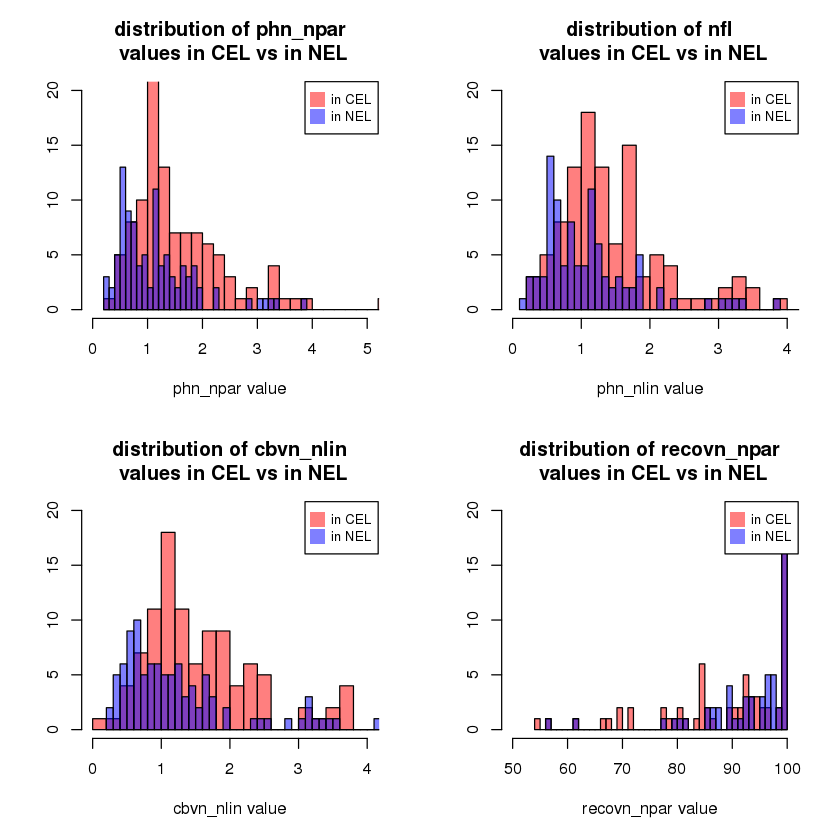

In [34]:
par(mfrow=c(2,2))
hist(recgli[which(recgli$in_CEL==1),]$phn_npar, breaks=35, ylim = c(0, 20),  xlim=c(0,5), col=rgb(1,0,0,0.5), xlab="phn_npar value", 
     ylab="", main="distribution of phn_npar\n values in CEL vs in NEL")
hist(recgli[which(recgli$in_NEL==1),]$phn_npar, breaks=35, ylim = c(0, 20),  xlim=c(0,5), col=rgb(0,0,1,0.5), add=T)
legend("topright", legend=c("in CEL","in NEL"), col=c(rgb(1,0,0,0.5), 
     rgb(0,0,1,0.5)), pt.cex=2, pch=15, cex = .8 )

hist(recgli[which(recgli$in_CEL==1),]$phn_nlin, breaks=35, ylim = c(0, 20),  xlim=c(0,4), col=rgb(1,0,0,0.5), xlab="phn_nlin value", 
     ylab="", main="distribution of nfl\n values in CEL vs in NEL")
hist(recgli[which(recgli$in_NEL==1),]$phn_nlin, breaks=35, ylim = c(0, 20),  xlim=c(0,4), col=rgb(0,0,1,0.5), add=T)
legend("topright", legend=c("in CEL","in NEL"), col=c(rgb(1,0,0,0.5), 
     rgb(0,0,1,0.5)), pt.cex=2, pch=15, cex = .8 )

hist(recgli[which(recgli$in_CEL==1),]$cbvn_nlin, breaks=35, ylim = c(0, 20),  xlim=c(0,4), col=rgb(1,0,0,0.5), xlab="cbvn_nlin value", 
     ylab="", main="distribution of cbvn_nlin\n values in CEL vs in NEL")
hist(recgli[which(recgli$in_NEL==1),]$cbvn_nlin, breaks=35, ylim = c(0, 20),  xlim=c(0,4), col=rgb(0,0,1,0.5), add=T)
legend("topright", legend=c("in CEL","in NEL"), col=c(rgb(1,0,0,0.5), 
     rgb(0,0,1,0.5)), pt.cex=2, pch=15, cex = .8 )

hist(recgli[which(recgli$in_CEL==1),]$recovn_npar, breaks=35, ylim = c(0, 20),  xlim=c(50,100), col=rgb(1,0,0,0.5), xlab="recovn_npar value", 
     ylab="", main="distribution of recovn_npar\n values in CEL vs in NEL")
hist(recgli[which(recgli$in_NEL==1),]$recovn_npar, breaks=35, ylim = c(0, 20),  xlim=c(50,100), col=rgb(0,0,1,0.5), add=T)
legend("topright", legend=c("in CEL","in NEL"), col=c(rgb(1,0,0,0.5), 
     rgb(0,0,1,0.5)), pt.cex=2, pch=15, cex = .8 )

## 2. Combining perfusion parameters to look at different associations within the GEE model: 

In [32]:
recgli$tumor_cell_evaluation = as.character(recgli$tumor_cell_evaluation)
recgli$tumor_cell_evaluation = as.numeric(recgli$tumor_cell_evaluation)


In [1]:
##dataset too small to fit: 
perf.fit = ordLORgee(formula = tumor_cell_evaluation ~ in_CEL, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(perf.fit)$coefficients

ERROR: Error in ordLORgee(formula = tumor_cell_evaluation ~ in_CEL, link = "logit", : could not find function "ordLORgee"
